In [328]:
%run functions.py
% run archive/silhouette_plotter.py

In [329]:
table = 'eth-tokens.test.clean_avg_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [330]:
df, dflabel = load_data_from_bigquery(table, label_table)

In [331]:
pipe, results = data_pipeline(df)

In [332]:
cl = cluster(results, n_clusters=8)

In [333]:
assign_cluster_to_data(df, dflabel, cl)

In [334]:
tsne_results = calc_tsne(results, perplexity=50,n_iter=2000)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.035s...
[t-SNE] Computed neighbors for 35917 samples in 16.473s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

For n_clusters = 2 The average silhouette_score is : 0.2862275652820668
For n_clusters = 3 The average silhouette_score is : 0.2410878140269812
For n_clusters = 4 The average silhouette_score is : 0.22015795111524314
For n_clusters = 5 The average silhouette_score is : 0.17794388860325083
For n_clusters = 6 The average silhouette_score is : 0.18287463873059415
For n_clusters = 7 The average silhouette_score is : 0.18556707408142564
For n_clusters = 8 The average silhouette_score is : 0.18496895940889946
For n_clusters = 9 The average silhouette_score is : 0.15517393240438584
For n_clusters = 10 The average silhouette_score is : 0.16400980826625947


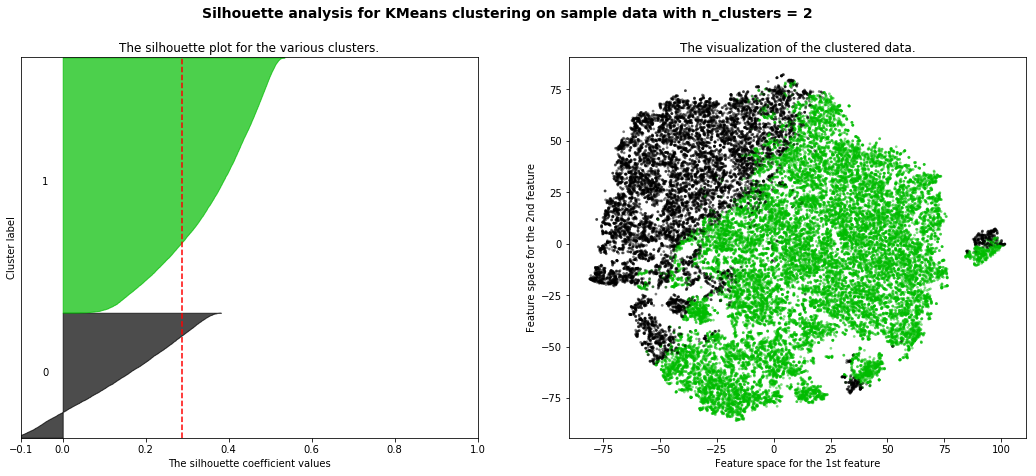

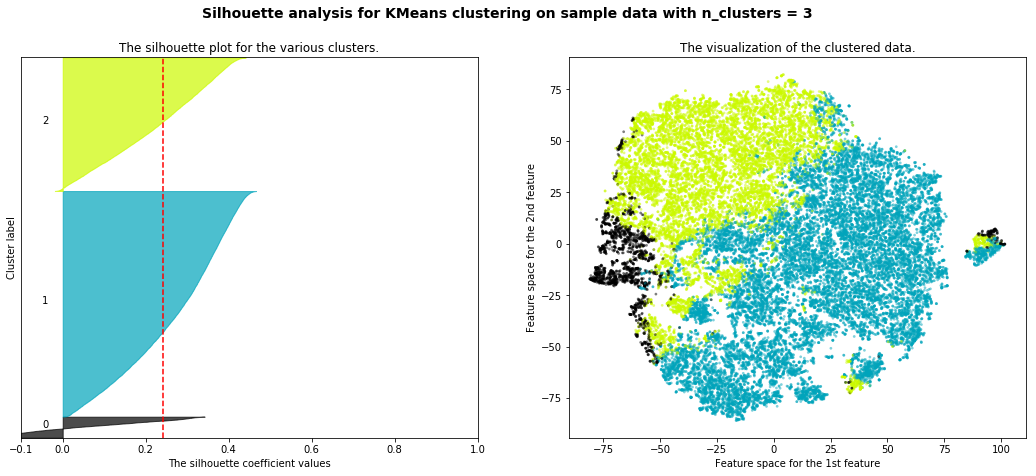

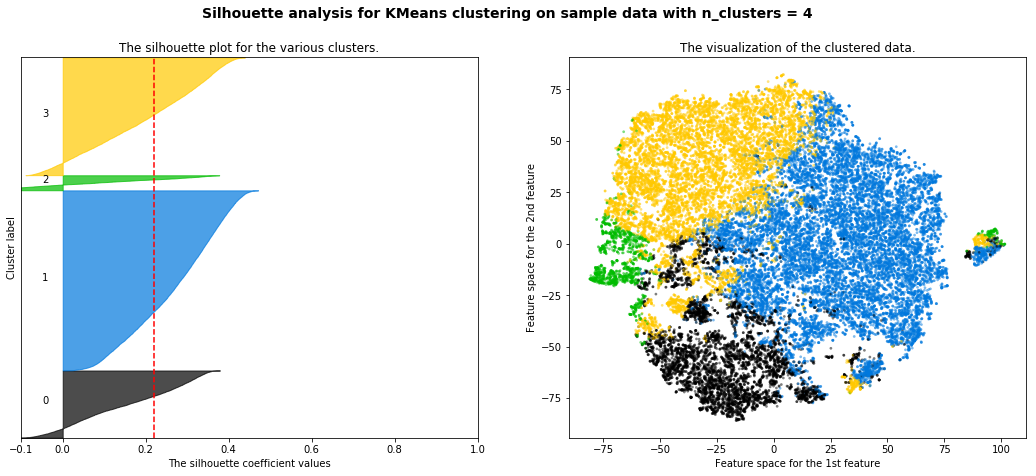

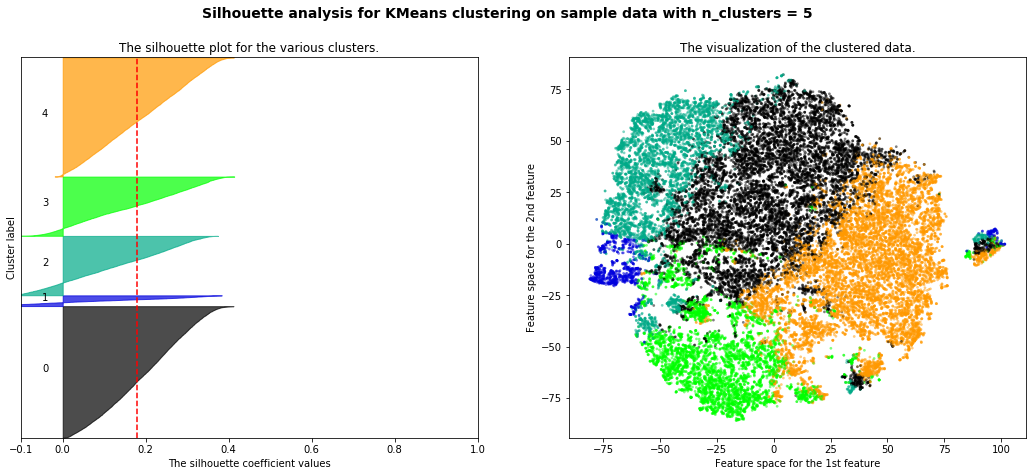

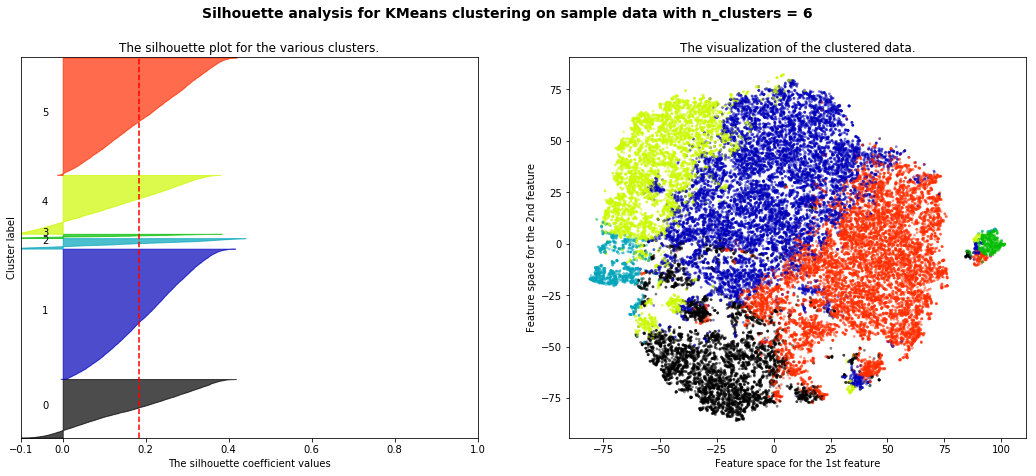

In [ ]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]
sils = silhouette_plotter(results, range_n_clusters, tsne_results)

In [ ]:
plot_tsne(cl, tsne_results)

In [ ]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining', 'ICO Wallets')
colors = ('green', 'blue', 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(cl,dflabel, category=c)

clusters= list(d.values())

In [ ]:
plot_tsne_with_labeled_clusters(tsne_results, cl, clusters, categs, colors)

In [ ]:
plot_tsne_with_labels(tsne_results,df, dflabel,categs,colors)

In [ ]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining')#, 'ICO Wallets')
colors = ('green', 'blue')#, 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(cl,dflabel, category=c)

clusters= list(d.values())

In [ ]:
#recluster with only clusters of interest - will help with separation

subpipe, subcl, subresults, newdf = recluster(df, cl, clusters, n_clusters=3)

In [ ]:
sub_tsne_results = calc_tsne(subresults)

In [ ]:
range_n_clusters = [2,3,4,5,6]
sub_sils = silhouette_plotter(subresults, range_n_clusters, sub_tsne_results)

In [ ]:
assign_cluster_to_data(newdf, dflabel, subcl)

In [ ]:
#highlighting clusters of interest

d = {}
for c in categs:
    d[c] = find_category_of_cluster(subcl,dflabel, category=c)

subclusters= list(d.values())

In [ ]:
plot_all(sub_tsne_results,subcl,newdf,dflabel,subclusters,categs,colors )


In [ ]:
mask = (cl.labels_==999)
for c in clusters:
    mask |= (cl.labels_==c)
np.sum(mask)

In [ ]:
import copy

In [ ]:
lbls = copy.deepcopy(cl.labels_)

In [ ]:
lbls[mask] =  [100+subcl.labels_[i] for i in range(len(subcl.labels_))]

In [ ]:
lbls

In [ ]:
clnew = copy.deepcopy(cl)

In [ ]:
clnew.labels_=lbls

In [ ]:
mask = np.array([c not in clusters for c in np.unique(cl.labels_) ])
clnew.cluster_centers_ = clnew.cluster_centers_[mask]

In [ ]:
clnew.n_clusters=cl.n_clusters - len(np.unique(clusters)) + subcl.n_clusters

In [ ]:
clnew.cluster_centers_ = np.vstack((clnew.cluster_centers_, subcl.cluster_centers_))

In [ ]:
assign_cluster_to_data(df, dflabel, clnew)

In [ ]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining', 'ICO Wallets')
colors = ('green', 'blue', 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(clnew,dflabel, category=c)

clusters= list(d.values())

In [ ]:
for clust in np.unique(clnew.labels_):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label','category']])
    print('\n\n\n')

In [ ]:
plot_all(tsne_results,clnew,df,dflabel,clusters,categs,colors )

In [ ]:
#original cluster
pca = pipe.named_steps['PCA']
scale =pipe.named_steps['scale']
log = pipe.named_steps['log']
c = cl.cluster_centers_
#transform back to real numbers
centroids = log.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
maindf_summary = pd.DataFrame(centroids, columns = df.columns[1:], index=np.unique(cl.labels_))

In [ ]:
#subcluster
pca = subpipe.named_steps['PCA']
scale =subpipe.named_steps['scale']
log = subpipe.named_steps['log']
c = subcl.cluster_centers_
#transform back to real numbers
centroids = log.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
subdf_summary = pd.DataFrame(centroids, columns = df.columns[1:], index=np.unique(subcl.labels_)+100)

In [ ]:
dfsummary = pd.concat((maindf_summary[mask], subdf_summary), axis=0)

In [ ]:
dfsummary

## Pickle results

In [ ]:
import pickle
pickle.dump(clnew, open( "pickles/cl.p", "wb" ) )
pickle.dump(clusters, open( "pickles/clusters.p", "wb" ) )
pickle.dump(categs, open( "pickles/categs.p", "wb" ) )
pickle.dump(colors, open( "pickles/colors.p", "wb" ) )
pickle.dump(df, open( "pickles/df.p", "wb" ) )
pickle.dump(dflabel, open( "pickles/dflabel.p", "wb" ) )
pickle.dump(dfsummary, open( "pickles/dfsummary.p", "wb" ) )

# pickle.dump(labeled_addresses, open( "pickles/labeled_addresses.p", "wb" ) )
# pickle.dump(cats, open( "pickles/cats.p", "wb" ) )
# pickle.dump(not_subset, open( "pickles/not_subset.p", "wb" ) )
# pickle.dump(labelmask, open( "pickles/labelmask.p", "wb" ) )